# AutoEncoder - MNIST - Removing Decoder and Ading Classifier

## Loading Packages + Data

In [1]:
%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


<b> Load Data: </b>


In [2]:
download =  datasets.MNIST('./MNIST/', train=True, download=True) 

0it [00:00, ?it/s]

9920512it [00:01, 7670533.15it/s]                             


Extracting ./MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST/MNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 109140.12it/s]           
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw


1654784it [00:00, 1896893.56it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST/MNIST\raw


8192it [00:00, 36135.21it/s]            
..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST\raw
Processing...
Done!


In [3]:
Datapath = 'MNIST/MNIST/raw/'

In [5]:
def get_int(b):
    """read and hexadicemal format and spit out integer format data"""
    return int(codecs.encode(b, 'hex'), 16)

In [6]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)  #The ord() function returns an integer representing the Unicode character.
    return b

In [7]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [8]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [9]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [10]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


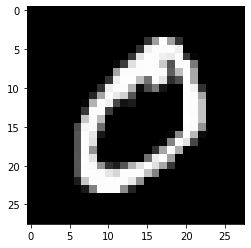

In [15]:
img = TrainImages[1,:].view((28,28)).numpy()
_=plt.imshow(img , cmap='gray')

In [11]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"    
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Define the Autoencoder:

<b> 784 -> 100 -> 784

In [16]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),       #Bottle-necked  
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 28*28),    #mapped back into the same size      
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
net = autoencoder()
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [19]:
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

In [22]:
##Storing weights of the Encoder for later visualization
init_weights = copy.deepcopy(net.encoder[0].weight.data)

<b> Define Optimization Technique: </b>


In [27]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

## Train Autoencoder + Testing

In [29]:
epochs = 10
BatchSize = 1000  #1000 images per batch ( 60,000 / 1000 = 60 batches of images)

In [33]:
for epoch in range(epochs):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)): #60
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255  # 0-1 norm. 
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.shape[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.079168
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.056736
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.043377
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.035148
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.030730
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.027878
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.025633
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.023974
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.022621
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.021615
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.020790
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.020047
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.019395
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.018663
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.018034
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.017608
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.017253
At Iteration : 18 / 30  ;  Mean-Squared 

 <b> Testing AutoEncoder Performance </b> 

In [52]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([2]))  #selecting 3rd image from test-set
#Picking a test image

In [53]:
#Passing Test image  to Autoencoder
outputImg = net((TestImg.double().to(device))/255).data
outputImg = (outputImg*255).byte()  #re-normalizing
outputImg = outputImg.view(-1,28,28)

if device == 'cuda':
    outputImg = outputImg.cpu()

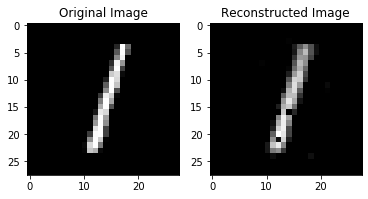

In [54]:
TestImg = TestImg.view(-1,28,28) #Original Image

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Encoder Weights Visualization:

In [56]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

In [ ]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

In [59]:
if use_gpu:
    init_weights = init_weights.view(-1,280,280).byte().cpu()
    trained_weights = trained_weights.view(-1,280,280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1,280,280).byte()

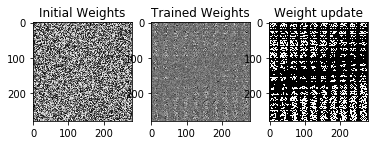

In [57]:
d_weights = init_weights - trained_weights   #CHNAGE IN WEIGHTS
 
fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Extracting Encoder and Adding Classification Layer

<b> Encoder Learns lower level rich features </b>

In [60]:
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [65]:
list(net.children())[:-1]

[Sequential(
   (0): Linear(in_features=784, out_features=100, bias=True)
   (1): ReLU()
 )]

In [66]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
# Final Layer = 10 alyer classifcation layer
print(net)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [67]:
net = net.double().to(device)

In [70]:
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

### Define Optimizer:


In [72]:
criterion = nn.NLLLoss()  #since LogSoftmax is used in last layer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Train Classifier:


In [73]:
iterations = 10
BatchSize = 1000

In [74]:
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
    inputs = TestImages.double()/255    
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if device == 'cuda':
        predicted = predicted.cpu()
        
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.shape[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

At Iteration: 1 / 10  ;  Training Loss: 1.282945 ; Testing Acc: 84.910004 
At Iteration: 2 / 10  ;  Training Loss: 0.530741 ; Testing Acc: 88.410004 
At Iteration: 3 / 10  ;  Training Loss: 0.433304 ; Testing Acc: 89.449997 
At Iteration: 4 / 10  ;  Training Loss: 0.392982 ; Testing Acc: 90.019997 
At Iteration: 5 / 10  ;  Training Loss: 0.369696 ; Testing Acc: 90.440002 
At Iteration: 6 / 10  ;  Training Loss: 0.354038 ; Testing Acc: 90.690002 
At Iteration: 7 / 10  ;  Training Loss: 0.342448 ; Testing Acc: 90.980003 
At Iteration: 8 / 10  ;  Training Loss: 0.333304 ; Testing Acc: 91.300003 
At Iteration: 9 / 10  ;  Training Loss: 0.325745 ; Testing Acc: 91.470001 
At Iteration: 10 / 10  ;  Training Loss: 0.319261 ; Testing Acc: 91.540001 
Finished Training


### Encoder Weights Visualization:


In [75]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

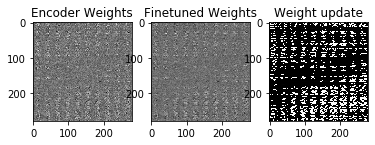

In [76]:
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,280,280).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,280,280).byte()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

### Classifier Weights Visualization:


In [77]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

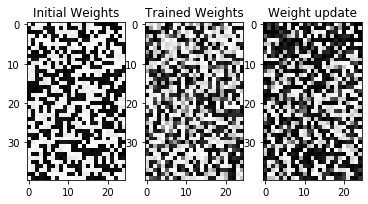

In [78]:
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

#  AutoEncoder - FMNIST - Removing Decoder and Ading Classifier

## Load Packages

In [88]:
%matplotlib inline
import os
import copy
import torch
import struct
import codecs
import numpy as np
import torchvision
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms, utils

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


## Load Data:

In [89]:
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

0it [00:00, ?it/s]

26427392it [00:01, 16391974.64it/s]                              


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


32768it [00:00, 270291.60it/s]                           
0it [00:00, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


4423680it [00:00, 14262117.30it/s]                            
8192it [00:00, 95510.04it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw
Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...


Done!


In [90]:
#loading the training data from trainset
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle = True)
#loading the test data from testset
testLoader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

In [91]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Define the Autoencoder:


<b>  178 -> 100 -> 100 -> 784</b>

In [92]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [93]:
net = autoencoder()
net = net.double().to(device)
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)


In [94]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

## Define Optimization Technique:


In [95]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

## Train Autoencoder:


In [96]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.shape[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.091705
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.076735
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.073744
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.065763
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.055291
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.047059
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.041876
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.038780
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.036594
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.034694
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.032774
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.031302
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.030129
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.029143
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.028285
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.027504
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.026750
At Iteration : 18 / 30  ;  Mean-Squared 

## Testing Autoencoder Performance:


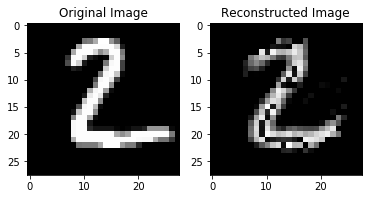

In [97]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))

outputImg = net((TestImg.double().to(device))/255).data
outputImg = (outputImg*255).byte()
outputImg = outputImg.view(-1,28,28)
if use_gpu:    
    outputImg = outputImg.cpu()

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Encoder Weights Visualization:


In [98]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

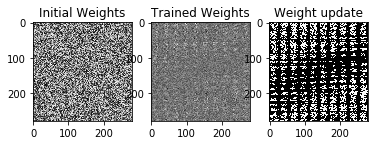

In [99]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(-1,280,280).byte().cpu()
    trained_weights = trained_weights.view(-1,280,280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1,280,280).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Remove Decoder and Add Classification Layer: 


In [100]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.double().to(device)
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


## Define Optimizer:


In [101]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Train Classifier:


In [102]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
    inputs = TestImages.double()/255
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if use_gpu:        
        predicted = predicted.cpu()
   
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.shape[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

At Iteration: 1 / 30  ;  Training Loss: 1.199231 ; Testing Acc: 85.470001 
At Iteration: 2 / 30  ;  Training Loss: 0.466156 ; Testing Acc: 88.889999 
At Iteration: 3 / 30  ;  Training Loss: 0.390452 ; Testing Acc: 90.029999 
At Iteration: 4 / 30  ;  Training Loss: 0.358876 ; Testing Acc: 90.620003 
At Iteration: 5 / 30  ;  Training Loss: 0.339126 ; Testing Acc: 90.970001 
At Iteration: 6 / 30  ;  Training Loss: 0.324461 ; Testing Acc: 91.419998 
At Iteration: 7 / 30  ;  Training Loss: 0.312459 ; Testing Acc: 91.709999 
At Iteration: 8 / 30  ;  Training Loss: 0.302053 ; Testing Acc: 91.860001 
At Iteration: 9 / 30  ;  Training Loss: 0.292492 ; Testing Acc: 92.199997 
At Iteration: 10 / 30  ;  Training Loss: 0.283423 ; Testing Acc: 92.389999 
At Iteration: 11 / 30  ;  Training Loss: 0.274880 ; Testing Acc: 92.610001 
At Iteration: 12 / 30  ;  Training Loss: 0.266725 ; Testing Acc: 92.750000 
At Iteration: 13 / 30  ;  Training Loss: 0.258862 ; Testing Acc: 92.879997 
At Iteration: 14 / 30

## Encoder Weights Visualization:


In [103]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

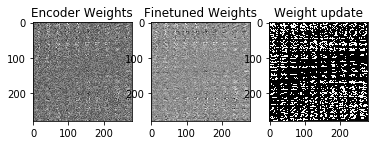

In [104]:
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,280,280).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,280,280).byte()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Classifier Weights Visualization:


In [105]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

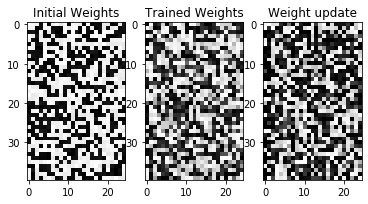

In [106]:
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

#  AutoEncoder - FMNIST - Layer Wise Pretraining

## Define the Autoencoder:


<b> 784 -> 100 -> 784 </b>

In [140]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [141]:
net = autoencoder()
net = net.double().to(device)
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [142]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

## Define Optimization Technique:


In [143]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

## Train Autoencoder:


In [144]:
iterations = 2
BatchSize = 500

In [145]:
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.shape[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 2  ;  Mean-Squared Error : 0.068452
At Iteration : 2 / 2  ;  Mean-Squared Error : 0.039381
Finished Training


## Testing Autoencoder Performance:


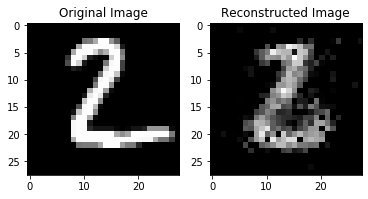

In [146]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
outputImg = net((TestImg.double().to(device))/255).data
outputImg = (outputImg*255).byte()
outputImg = outputImg.view(-1,28,28)
if use_gpu:    
    outputImg = outputImg.cpu()

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Adding more Layers:


Old :: (784 -> 100 -> 784)

In [147]:
print("PREVIOUSLY TRAINED AUTOENCODER ::::::")
print("********************************")
print("********************************")
print(net)

PREVIOUSLY TRAINED AUTOENCODER ::::::
********************************
********************************
autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [148]:
net.encoder

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
)

In [149]:
net.decoder

Sequential(
  (0): Linear(in_features=100, out_features=784, bias=True)
  (1): ReLU()
)

784 - > 100 - > 100

In [150]:
net.encoder.add_module('layer', nn.Sequential(nn.Linear(100, 100),nn.ReLU()))
net.decoder  = nn.Sequential(nn.Linear(100, 100),nn.ReLU(),net.decoder)
print(net)
net = net.double().to(device)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (layer): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
      (1): ReLU()
    )
  )
)


In [151]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.shape[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.078204
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.063512
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.057327
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.051649
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.047525
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.044345
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.041870
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.039949
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.038259
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.036808
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.035643
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.034638
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.033752
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.032966
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.032245
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.031474
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.030833
At Iteration : 18 / 30  ;  Mean-Squared 

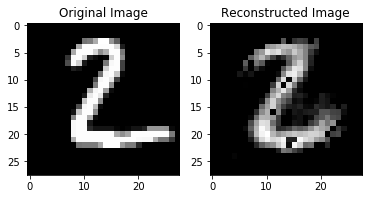

In [152]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))

outputImg = net((TestImg.double().to(device))/255).data
outputImg = (outputImg*255).byte()
outputImg = outputImg.view(-1,28,28)
if use_gpu:    
    outputImg = outputImg.cpu()

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

## Remove Decoder and Add Classification Layer: 


In [153]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
new_classifier = nn.Sequential(*list(new_classifier[0].children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.double().to(device)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


## Define Optimizer:


In [154]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Train Classifier:


In [155]:
iterations = 5
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    inputs = TestImages.double()/255
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if use_gpu:        
        predicted = predicted.cpu()
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.shape[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

At Iteration: 1 / 5  ;  Training Loss: 1.363466 ; Testing Acc: 84.860001 
At Iteration: 2 / 5  ;  Training Loss: 0.476736 ; Testing Acc: 87.690002 
At Iteration: 3 / 5  ;  Training Loss: 0.426773 ; Testing Acc: 88.709999 
At Iteration: 4 / 5  ;  Training Loss: 0.399779 ; Testing Acc: 89.440002 
At Iteration: 5 / 5  ;  Training Loss: 0.380454 ; Testing Acc: 89.980003 
Finished Training
